In [1]:
# https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

2022-07-31 19:41:27.701604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-31 19:41:27.701664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [35]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [43]:
df = df.sort_values('Date')
df = df[df["Date"] > "2017-01-01"]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2361,2017-01-02,995.440002,1031.680054,990.200012,1017.049988,1017.049988,66038073
2362,2017-01-03,1017.049988,1035.469971,1006.530029,1033.300049,1033.300049,56085870
2363,2017-01-04,1033.300049,1148.540039,1022.320007,1135.410034,1135.410034,170584623
2364,2017-01-05,1135.410034,1150.630005,874.530029,989.349976,989.349976,244839289
2365,2017-01-06,989.349976,1027.420044,852.549988,886.159973,886.159973,179160668


In [44]:
df.shape

(840, 7)

Text(0, 0.5, 'Close Price (USD)')

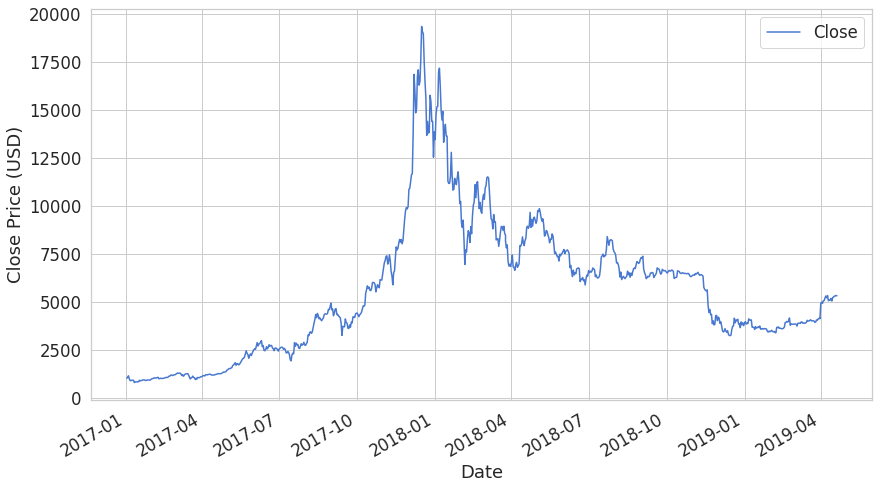

In [45]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [46]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [47]:
scaled_close.shape

(840, 1)

In [48]:
np.isnan(scaled_close).any()

False

In [49]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [50]:
scaled_close = scaled_close.reshape(-1, 1)

In [51]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [59]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)
a=1

In [53]:
X_train.shape

(703, 99, 1)

In [54]:
X_test.shape

(37, 99, 1)

# Model

In [55]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [56]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [57]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    verbose=2
)

Epoch 1/50
10/10 - 41s - loss: 0.0261 - val_loss: 0.0033 - 41s/epoch - 4s/step
Epoch 2/50


KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();